<a href="https://colab.research.google.com/github/mrm1404/Style-Transfer-Using-CycleGAN/blob/main/Style_Transfer_Using_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MRI Images Style Transfer Using CycleGAN

This Notebook illustrates MRI Image Conversion from one Type (Tr1) to another MRI type (Tr2) using CycleGAN architecture

**Steps Involved :**
1. Importing Libraries
2. Data Downloading & Loading
3. Data Preprocessing & Visualization
4. Model Building
5. Model Training
6. Model Test Accuracy
7. Generation of an GIF Image 

### **1. Importing Libraries**

In [1]:
## Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import imageio
import glob
import cv2
import os
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator

### **2.1. Data Downloading**


In [2]:
!wget -q https://github.com/mrm1404/Style-Transfer-Using-CycleGAN/raw/main/Dataset/MRI%2BT1_T2%2BDataset.RAR

### **2.2. Data Loading**

In [3]:
## Data Extraction
!unrar x "/content/MRI+T1_T2+Dataset.RAR"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/MRI+T1_T2+Dataset.RAR

Creating    Tr1                                                       OK
Extracting  Tr1/.DS_Store                                                  0%  OK 
Creating    Tr1/TrainT1                                               OK
Extracting  Tr1/TrainT1/Image #10.png                                      1%  OK 
Extracting  Tr1/TrainT1/Image #11.png                                      2%  OK 
Extracting  Tr1/TrainT1/Image #12.png                                      3%  OK 
Extracting  Tr1/TrainT1/Image #13.png                                      4%  OK 
Extracting  Tr1/TrainT1/Image #14.png                                      5%  OK 
Extracting  Tr1/TrainT1/Image #15.png                                      6%  OK 
Extracting  Tr1/TrainT1/Image #16.png                                      7%  OK 
E

In [4]:
## Method to get List of Images with different extensions
#### From the Directory path specified
def getImageListFromFolder(folderpath, ext=['png']):
  files = []
  [files.extend(glob.glob(folderpath + '*.' + e)) for e in ext]
  images = []
  if len(files) > 1:
    images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in files]
  return images

In [5]:
## Loading MRI Images into specific MRI type list 
tr1_img_directory = "/content/Tr1/TrainT1/"
tr2_img_directory = "/content/Tr2/TrainT2/"
tr1_images_lst =[]
tr1_images_lst= getImageListFromFolder(tr1_img_directory)
tr2_images_lst= getImageListFromFolder(tr2_img_directory)
print("No of Tr1 MRI Images: ", len(tr1_images_lst))
print("No of Tr2 MRI Images: ", len(tr2_images_lst))

No of Tr1 MRI Images:  43
No of Tr2 MRI Images:  46


### **3. Data Pre-Processing & Visualization**
- Cropping
- Resizing
- Reshaping
- Shuffle and Batch 
- Data Visualization

In [6]:
## Loading Tr1 Data, Cropping Images & Resizing Images
tr1_data = np.zeros((len(tr1_images_lst), 128, 128))
for index, img in enumerate(tr1_images_lst):
    cropped_img = img[20:200,1:181]
    tr1_data[index,:,:] = resize(cropped_img, (128,128))
tr1_data.shape

(43, 128, 128)

In [7]:
## Loading Tr2 Data, Cropping Images & Resizing Images
tr2_data = np.zeros((len(tr2_images_lst), 128, 128))
for index, img in enumerate(tr2_images_lst):
    cropped_img = img[20:200,1:181]
    tr2_data[index, :, :] = resize(cropped_img, (128,128))
tr2_data.shape

(46, 128, 128)

In [8]:
## Data Reshaping
tr1_data = tr1_data.reshape(tr1_data.shape[0], 128, 128, 1).astype('float32')
tr2_data = tr2_data.reshape(tr2_data.shape[0], 128, 128, 1).astype('float32')

In [9]:
## Defining Constants
BATCH_SIZE = 5

In [10]:
## Shuffling the Images and Setting Batch Input Layers
tr1_data = tf.data.Dataset.from_tensor_slices(tr1_data).shuffle(tr1_data[0].shape[0], seed=42).batch(BATCH_SIZE)
tr2_data = tf.data.Dataset.from_tensor_slices(tr2_data).shuffle(tr2_data[0].shape[0], seed=42).batch(BATCH_SIZE)

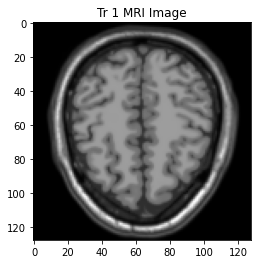

In [11]:
## Data Visualization of Tr1 Type MRI Image Data
sample_tr1_data = next(iter(tr1_data))
plt.imshow(sample_tr1_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('Tr 1 MRI Image')
plt.axis('on')
plt.show()

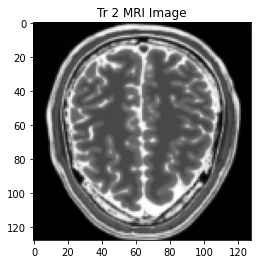

In [12]:
## Data Visualization of Tr2 Type MRI Image Data
sample_tr2_data = next(iter(tr2_data))
plt.imshow(sample_tr2_data[0].numpy()[:, :, 0], cmap='gray')
plt.title('Tr 2 MRI Image')
plt.axis('on')
plt.show()

### **4. Model Building**
- Instance Normalization
- Downsampling, Upsampling, Unet
- Generator Building
- Discriminator Building

In [13]:
## Instance Normalization
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [14]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [16]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(256, 4, False), # (bs, 64, 64, 256)
        downsample(512, 4), # (bs, 32, 32, 512)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4) # (bs, 1, 1, 512)
    ]
    up_stack = [
        upsample(512, 4, True), # (bs, 2, 2, 512)
        upsample(512, 4, True), # (bs, 4, 4, 512)
        upsample(512, 4, True), # (bs, 8, 8, 512)
        upsample(512, 4, True), # (bs, 16, 16, 512)
        upsample(512, 4), # (bs, 32, 32, 512)
        upsample(256, 4) # (bs, 64, 64, 256)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 128, 128, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
generator_g = unet_generator()
generator_f = unet_generator()

In [18]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 256)  4096        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 32, 512)  2098176     ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 512)  4195328     ['sequential_1[0][0]']       

In [19]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (128, 128, 1)
    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(256, 4, False)(x) # (bs, 64, 64, 256)
    down2 = downsample(512, 4)(down1) # (bs, 32, 32, 512)
    down3 = downsample(512, 4)(down2) # (bs, 16, 16, 512)
    down4 = downsample(512, 4)(down3) # (bs, 8, 8, 512)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 10, 10, 512)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [20]:
discriminator_x = discriminator()
discriminator_y = discriminator()

In [21]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 sequential_26 (Sequential)  (None, 64, 64, 256)       4096      
                                                                 
 sequential_27 (Sequential)  (None, 32, 32, 512)       2098176   
                                                                 
 sequential_28 (Sequential)  (None, 16, 16, 512)       4195328   
                                                                 
 sequential_29 (Sequential)  (None, 8, 8, 512)         4195328   
                                                                 
 zero_padding2d (ZeroPadding  (None, 10, 10, 512)      0         
 2D)                                                             
                                                           

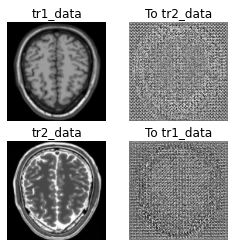

In [22]:
to_tr1_data = generator_g(sample_tr1_data)
to_tr2_data = generator_f(sample_tr2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_tr1_data, to_tr2_data, sample_tr2_data, to_tr1_data]
title = ['tr1_data', 'To tr2_data', 'tr2_data', 'To tr1_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

In [23]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [25]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [26]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [27]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

In [28]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
EPOCHS = 15

In [30]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [31]:
def generate_images(model1, test_input1, model2, test_input2):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [32]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1_data, tr2_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1_data, generator_f, sample_tr2_data)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)